# **EDA of 400 samples from amazon_del**  
Here I am doing an EDA on this sample in order to prepare them for a prediction model of Delivery time.  

## **Packages**

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from geopy.geocoders import Nominatim
import haversine as hs
from haversine import Unit
from modules_amazon import Location
import pickle

In [110]:
with open("amazon_sample400.pkl", "rb") as f:
    amazon_sample400 = pickle.load(f)

# **Checking** 

In [111]:
print(amazon_sample400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                398 non-null    object         
 1   Agent_Age               398 non-null    int64          
 2   Agent_Rating            398 non-null    float64        
 3   Store_Latitude          398 non-null    float64        
 4   Store_Longitude         398 non-null    float64        
 5   Drop_Latitude           398 non-null    float64        
 6   Drop_Longitude          398 non-null    float64        
 7   Order_Date              398 non-null    datetime64[ns] 
 8   Order_Time              398 non-null    object         
 9   Pickup_Time             398 non-null    datetime64[ns] 
 10  Weather                 398 non-null    object         
 11  Traffic                 398 non-null    category       
 12  Vehicle                 398 non-null

In [112]:
amazon_sample400.drop(["Store_Latitude","Store_Longitude"], axis=1, inplace=True)

## **Cities**  
I have previously define the cities using the modules_amazon. However, in the EDA of the amazon_delivery I found 3180 rows with null coordinates of Store (represents around 7% of the all dataset).  
Here, I will check the cities that loc.city() had found. Especially where the corrdinates of the Store were null.

In [113]:
print(amazon_sample400["City"].isna().sum())
no_city = amazon_sample400[amazon_sample400["City"].isna()]
no_city

1


,Order_ID,Agent_Age,Agent_Rating,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance_Store_Drop_km,abs_Store_Latitude,abs_Store_Longitude,duration,duration_min,City
14998,nqmv986411624,37,4.6,18.556216,73.882527,2022-03-07,13:50:00,2024-12-05 14:00:00,Sunny,High,motorcycle,Metropolitan,130,Snacks,6.129158,18.516216,73.842527,0 days 00:10:00,10.0,None


In [114]:
loc = Location(18.5,73.8)
city = loc.city()

In [115]:
print(city)
print(loc.country())

Pune City
India


In [116]:
Pune_City = amazon_sample400[amazon_sample400["City"] == city]
print(Pune_City.info())
print(Pune_City[["abs_Store_Latitude","abs_Store_Longitude"]].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 3400 to 18798
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                34 non-null     object         
 1   Agent_Age               34 non-null     int64          
 2   Agent_Rating            34 non-null     float64        
 3   Drop_Latitude           34 non-null     float64        
 4   Drop_Longitude          34 non-null     float64        
 5   Order_Date              34 non-null     datetime64[ns] 
 6   Order_Time              34 non-null     object         
 7   Pickup_Time             34 non-null     datetime64[ns] 
 8   Weather                 34 non-null     object         
 9   Traffic                 34 non-null     category       
 10  Vehicle                 34 non-null     category       
 11  Area                    34 non-null     category       
 12  Delivery_Time           34 non-null  

In [117]:
amazon_sample400["City"] = amazon_sample400["City"].fillna("Pune City")

I apparently don't have any null Store coordinates values in my sample.  
The only null City value was one that was found to be in Pune City. During the calculation (which requires internet access) this row might have been skipped.  

In [118]:
print(amazon_sample400["City"].unique())

['' 'Kolkata' 'Surat' 'Bengaluru' 'Prayagraj' 'Mysuru' 'Mumbai Suburban'
 'Chhatrapati Sambhaji Nagar' 'Hyderabad' 'Kanpur' 'Pune City' 'Chennai'
 'Ranchi' 'Ludhiana' 'Jaipur' 'Ernakulam' 'Bhopal' 'Indore' 'Mumbai City'
 'Agra' 'Vadodara' 'Coimbatore' 'Dehradun' 'Thane' 'Panaji']


In [119]:
empty_cities = amazon_sample400[amazon_sample400["City"] == ""]
print(empty_cities[["abs_Store_Latitude","abs_Store_Longitude"]].describe())

       abs_Store_Latitude  abs_Store_Longitude
count          103.000000           103.000000
mean            11.804214            55.019124
std              8.357637            33.846224
min              0.000000             0.000000
25%              0.000000             0.000000
50%             12.933284            73.165012
75%             21.149669            76.997008
max             30.885814            80.249982


In [120]:
print(empty_cities["Area"].value_counts())

Area
Metropolitan    85
Urban           16
Other            2
Semi-Urban       0
Name: count, dtype: int64


I won't remove them. I have a total of 103 null Store coordinates. However, I have the Area information which can be useful when comparing the traffic.

# **Validation of the features for the predictive model**

## **Are the cities that relevant?**  
The problem is that the number of cities is very large (24 + unknowns). This can be problematique for the model.  
If there is no relationship between the cities and delivery time we can not only remove this feature but also the coordinates (Store and Drop since I have calculated the distance already).  
I will perhaps need to find the size of the population of each city and/or their geographical situations.

In [121]:
amazon_sample400["City"] = amazon_sample400["City"].replace("","Unknown")
print(amazon_sample400["City"].value_counts(normalize=True))

City
Unknown                       0.258794
Mysuru                        0.090452
Pune City                     0.087940
Jaipur                        0.057789
Mumbai Suburban               0.055276
Hyderabad                     0.055276
Ranchi                        0.055276
Chennai                       0.050251
Bengaluru                     0.042714
Indore                        0.042714
Surat                         0.032663
Coimbatore                    0.020101
Kanpur                        0.017588
Kolkata                       0.017588
Chhatrapati Sambhaji Nagar    0.015075
Prayagraj                     0.015075
Bhopal                        0.015075
Ludhiana                      0.015075
Mumbai City                   0.012563
Agra                          0.012563
Ernakulam                     0.010050
Vadodara                      0.007538
Dehradun                      0.007538
Thane                         0.002513
Panaji                        0.002513
Name: proportion, dt

In [122]:
print(amazon_sample400["Area"].value_counts())

Area
Metropolitan    313
Urban            77
Other             8
Semi-Urban        0
Name: count, dtype: int64


I have no Semi-Urban in this sample.  
I have to remember to check this category in amazon_del

In [123]:
amazon_sample400["Area"] = amazon_sample400["Area"].cat.remove_categories("Semi-Urban")

In [124]:
area_cities = amazon_sample400.groupby("Area")["City"].unique()
area_cities

C:\Users\Angelique\AppData\Local\Temp\ipykernel_23784\1398955054.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_cities = amazon_sample400.groupby("Area")["City"].unique()


Area
Other           [Unknown, Hyderabad, Mumbai Suburban, Bengalur...
Urban           [Unknown, Mysuru, Mumbai Suburban, Hyderabad, ...
Metropolitan    [Unknown, Kolkata, Surat, Bengaluru, Prayagraj...
Name: City, dtype: object

In [125]:
print(area_cities["Metropolitan"])

['Unknown' 'Kolkata' 'Surat' 'Bengaluru' 'Prayagraj' 'Mumbai Suburban'
 'Chhatrapati Sambhaji Nagar' 'Mysuru' 'Kanpur' 'Pune City' 'Hyderabad'
 'Chennai' 'Ranchi' 'Ludhiana' 'Jaipur' 'Ernakulam' 'Bhopal' 'Indore'
 'Agra' 'Vadodara' 'Coimbatore' 'Mumbai City' 'Thane' 'Panaji' 'Dehradun']


In [126]:
print(area_cities["Urban"])

['Unknown' 'Mysuru' 'Mumbai Suburban' 'Hyderabad' 'Kolkata' 'Ranchi'
 'Pune City' 'Jaipur' 'Chennai' 'Bengaluru' 'Mumbai City' 'Kanpur'
 'Ludhiana' 'Surat' 'Bhopal' 'Dehradun' 'Agra' 'Indore' 'Coimbatore']


In [127]:
print(area_cities["Other"])

['Unknown' 'Hyderabad' 'Mumbai Suburban' 'Bengaluru' 'Coimbatore'
 'Ernakulam' 'Ranchi']


Same cities appear in both Urban,Metropolitan and Other areas. 

In [128]:
print(amazon_sample400.groupby("Traffic")["Area"].value_counts())

Traffic  Area        
Low      Metropolitan    106
         Urban            31
         Other             3
Medium   Metropolitan     75
         Urban            18
         Other             3
High     Metropolitan     39
         Urban            12
         Other             2
Jam      Metropolitan     93
         Urban            16
         Other             0
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_23784\3871292136.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(amazon_sample400.groupby("Traffic")["Area"].value_counts())


I think we can remove the following features:  
- City;  
- abs_Store_Latitude;  
- abs_Store_Longitude;  
- Drop_Latitude;  
- Drop_Longitude;  


## **Removing the above features**

In [129]:
samples400 = amazon_sample400.drop(["City","abs_Store_Latitude","abs_Store_Longitude","Drop_Latitude","Drop_Longitude"], axis=1)
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Order_ID                398 non-null    object         
 1   Agent_Age               398 non-null    int64          
 2   Agent_Rating            398 non-null    float64        
 3   Order_Date              398 non-null    datetime64[ns] 
 4   Order_Time              398 non-null    object         
 5   Pickup_Time             398 non-null    datetime64[ns] 
 6   Weather                 398 non-null    object         
 7   Traffic                 398 non-null    category       
 8   Vehicle                 398 non-null    category       
 9   Area                    398 non-null    category       
 10  Delivery_Time           398 non-null    int64          
 11  Category                398 non-null    object         
 12  Distance_Store_Drop_km  398 non-null

## **Validation of the duration**  
Is there a relationship between the duration (time between order and pickup) and the delivery time?  


<Axes: xlabel='duration_min', ylabel='Delivery_Time'>

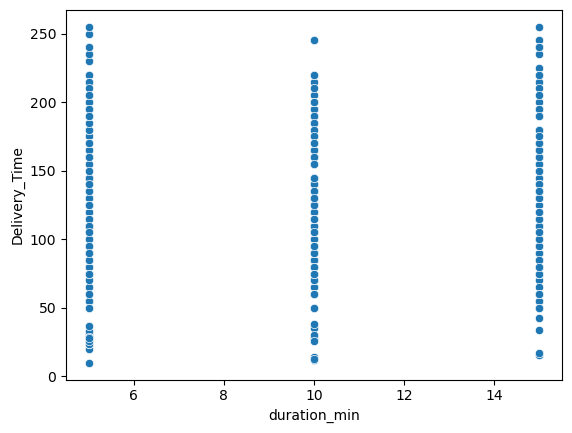

In [130]:
sns.scatterplot(x="duration_min", y="Delivery_Time", data=samples400)

In [131]:
print(samples400["duration_min"].value_counts())

duration_min
5.0     137
10.0    135
15.0    126
Name: count, dtype: int64


<Axes: xlabel='duration_min', ylabel='Delivery_Time'>

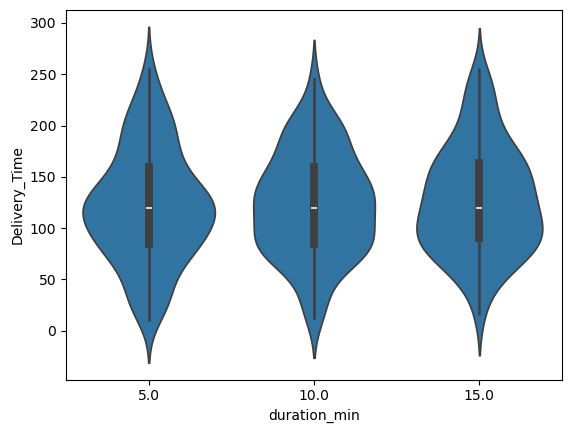

In [132]:
samples400["duration_min"] = samples400["duration_min"].astype("category")
sns.violinplot(x="duration_min", y="Delivery_Time", data=samples400)

There are no obvious differences between the 3 durations.  
I can remove the duration.

In [133]:
samples400.drop(["duration","duration_min"], axis=1, inplace=True)

## **Does the day matter?**  
I am not sure wheter in India sunday is the day rest.  
Maybe we should se a difference if one of the day of the week is a rest day.

In [134]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Age               398 non-null    int64         
 2   Agent_Rating            398 non-null    float64       
 3   Order_Date              398 non-null    datetime64[ns]
 4   Order_Time              398 non-null    object        
 5   Pickup_Time             398 non-null    datetime64[ns]
 6   Weather                 398 non-null    object        
 7   Traffic                 398 non-null    category      
 8   Vehicle                 398 non-null    category      
 9   Area                    398 non-null    category      
 10  Delivery_Time           398 non-null    int64         
 11  Category                398 non-null    object        
 12  Distance_Store_Drop_km  398 non-null    float64   

In [135]:
print(samples400["Order_Date"].min())
print(samples400["Order_Date"].max())

2022-02-11 00:00:00
2022-04-06 00:00:00


In [136]:
samples400["Order_Day"] = samples400["Order_Date"].dt.weekday


<Axes: xlabel='Order_Day', ylabel='Delivery_Time'>

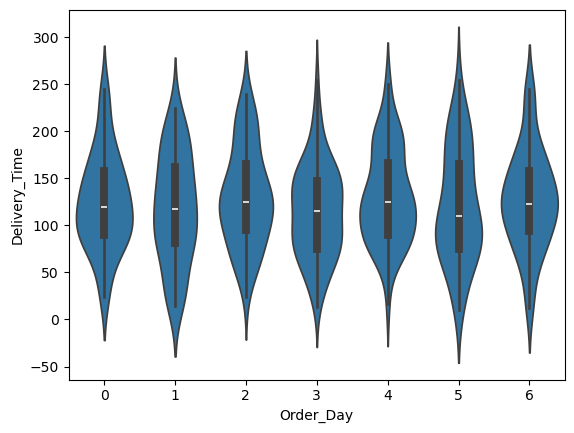

In [137]:
sns.violinplot(x="Order_Day", y="Delivery_Time", data=samples400)

The shape distribution of the delivery time is slightly different between the weekdays.  
So I think it's worth to keep this feature but perhaps we can remove the Order_date as it is redundant.  
I am also removing Order_Time as we saw above that there is no relationship between the time spent between order and pickup and Delivery_Time.

In [138]:
samples400.drop(["Order_Date","Order_Time"], axis=1, inplace=True)

In [139]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Age               398 non-null    int64         
 2   Agent_Rating            398 non-null    float64       
 3   Pickup_Time             398 non-null    datetime64[ns]
 4   Weather                 398 non-null    object        
 5   Traffic                 398 non-null    category      
 6   Vehicle                 398 non-null    category      
 7   Area                    398 non-null    category      
 8   Delivery_Time           398 non-null    int64         
 9   Category                398 non-null    object        
 10  Distance_Store_Drop_km  398 non-null    float64       
 11  Order_Day               398 non-null    int32         
dtypes: category(3), datetime64[ns](1), float64(2), int

## **Agent Age**

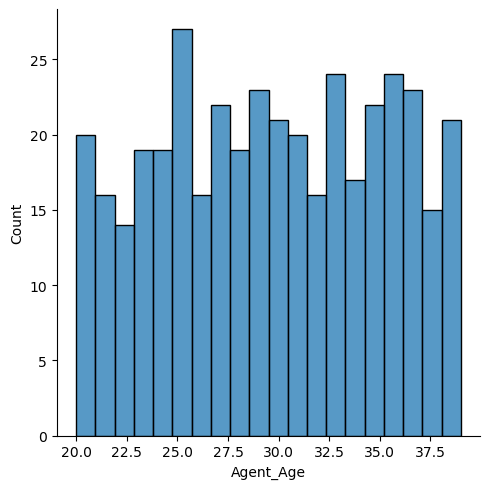

In [140]:
sns.displot(samples400["Agent_Age"], bins=20)

The distribution of the agent age is closer to a uniform distribution. 

<Axes: xlabel='Agent_Age', ylabel='Delivery_Time'>

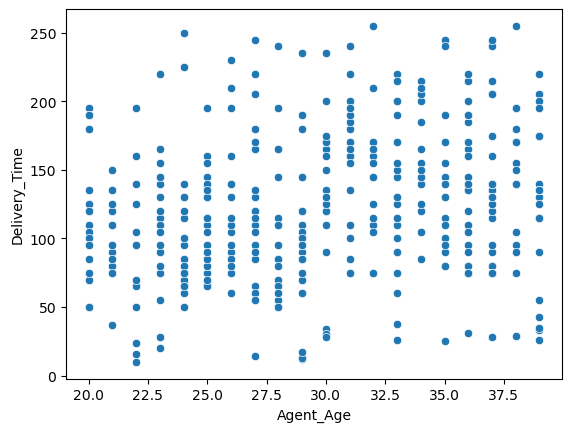

In [141]:
sns.scatterplot(x="Agent_Age", y="Delivery_Time", data=samples400)

We do not have a linear relationship, but we can see 2 categories:  
- More or equal 30 years old;  
- < 30 years old.  
I will make a column with these 2 categories and see if we can see differences.

### **The under 30 vs the older agents**

In [142]:
samples400["Young_vs_Older_Agents"] = np.where(samples400["Agent_Age"] < 30, "Under 30","30+")
samples400["Young_vs_Older_Agents"] = samples400["Young_vs_Older_Agents"].astype("category")
order_age_range = ["Under 30", "30+"]
samples400["Young_vs_Older_Agents"] = samples400["Young_vs_Older_Agents"].cat.\
    reorder_categories(new_categories=order_age_range, ordered=True)

<Axes: xlabel='Young_vs_Older_Agents', ylabel='Delivery_Time'>

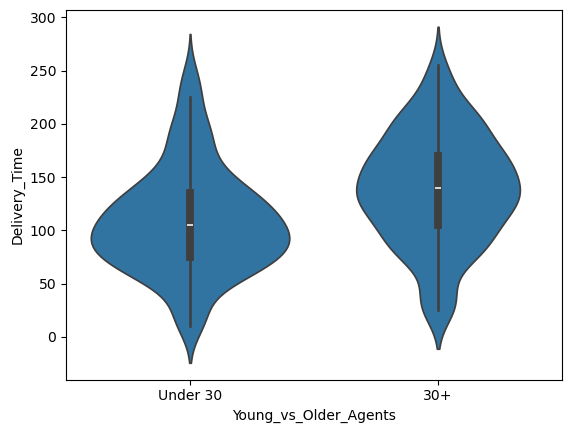

In [143]:
sns.violinplot(x="Young_vs_Older_Agents", y="Delivery_Time", data=samples400)

We can see a difference between young and older agents. Is that difference significative?  
If it is then I will keep this fetaure.  
I will do a Mann-Whitney U test.  

In [144]:
from scipy.stats import mannwhitneyu

age_stat, age_pval = mannwhitneyu(samples400[samples400["Young_vs_Older_Agents"] == "Under 30"]["Delivery_Time"],\
                                  samples400[samples400["Young_vs_Older_Agents"] == "30+"]["Delivery_Time"])
print(age_pval)

6.278748055650641e-10


The difference (of the median Delivery_Time values) is largely significantly different.  
I will keep this feature but I will remove the Agent_Age feature as among each age caetgory there are no obvious patterns (see scatterplot).  

In [145]:
samples400 = samples400.drop("Agent_Age", axis=1)

In [146]:
print(samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, 6607 to 18798
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                398 non-null    object        
 1   Agent_Rating            398 non-null    float64       
 2   Pickup_Time             398 non-null    datetime64[ns]
 3   Weather                 398 non-null    object        
 4   Traffic                 398 non-null    category      
 5   Vehicle                 398 non-null    category      
 6   Area                    398 non-null    category      
 7   Delivery_Time           398 non-null    int64         
 8   Category                398 non-null    object        
 9   Distance_Store_Drop_km  398 non-null    float64       
 10  Order_Day               398 non-null    int32         
 11  Young_vs_Older_Agents   398 non-null    category      
dtypes: category(4), datetime64[ns](1), float64(2), int

## **Agent_Rating**

<Axes: xlabel='Agent_Rating', ylabel='Delivery_Time'>

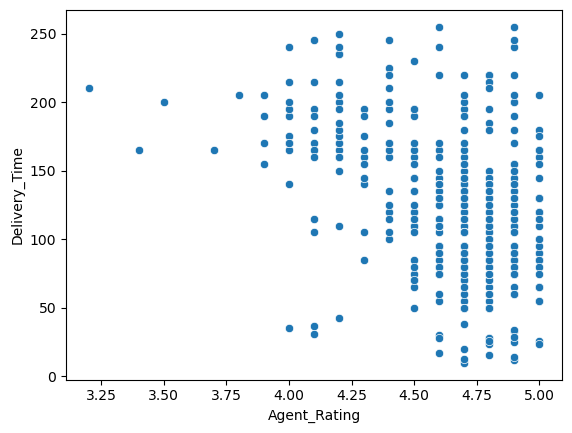

In [147]:
sns.scatterplot(x="Agent_Rating", y="Delivery_Time", data=samples400)

I can see a negative relationship between the rating and the delivery time. Shorter is the delivery, better is the rating.

In [149]:
print(samples400["Agent_Rating"].describe())
rating_inf4 = samples400[samples400["Agent_Rating"] < 4]
print(len(rating_inf4)/len(samples400))

count    398.000000
mean       4.633920
std        0.293987
min        3.200000
25%        4.500000
50%        4.700000
75%        4.800000
max        5.000000
Name: Agent_Rating, dtype: float64
0.022613065326633167


I'm keeping the feature the way it is.

## **Pickup_Time**  
I will make a column to group the data by the hours.

<Axes: xlabel='Pickup_Time_hour', ylabel='Delivery_Time'>

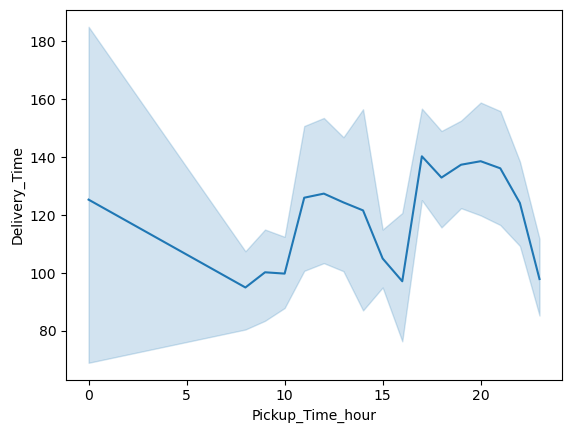

In [150]:
samples400["Pickup_Time_hour"] = samples400["Pickup_Time"].dt.hour
sns.lineplot(x="Pickup_Time_hour", y="Delivery_Time", data=samples400)

In [153]:
print(samples400["Pickup_Time_hour"].value_counts())

Pickup_Time_hour
22    47
19    46
18    39
23    35
20    35
17    34
21    33
10    24
9     20
11    20
12    17
14    13
8     10
13     8
16     7
0      6
15     4
Name: count, dtype: int64


There are no data between 0 and 8, which is expected. However we do have 6 rows for a pickup between midnight and 1am. 

In [154]:
samples400["Pickup_Time_hour"] = samples400["Pickup_Time_hour"].astype("category")
ordered_hours = [0,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
samples400["Pickup_Time_hour"] = samples400["Pickup_Time_hour"].cat.\
    reorder_categories(new_categories=ordered_hours, ordered=True)

<Axes: xlabel='Pickup_Time_hour', ylabel='Delivery_Time'>

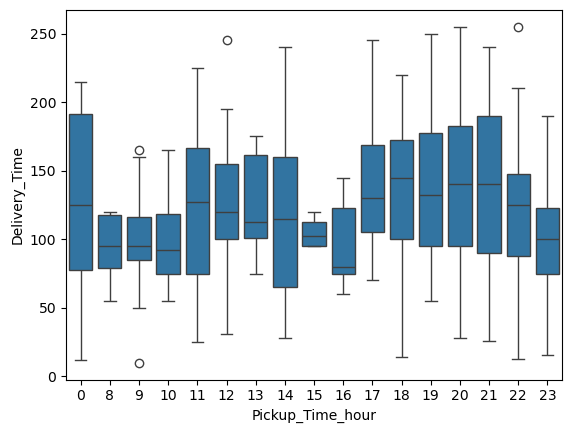

In [157]:
sns.boxplot(x="Pickup_Time_hour", y="Delivery_Time", data=samples400)